In [1]:
# Plot ad hoc CIFAR10 instances
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2gray

In [2]:
# Running on an Quadro RTX 4000 (Similar to RTX 2070) Set memory limit else it is out of memory
gpus= tf.config.list_physical_devices('GPU') 
print(gpus)
tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## (a)

In [3]:
# load data
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
# create a grid of 3x3 images

print(y_train.shape)
index_bird_train = np.where(y_train == 2)
index_bird_test = np.where(y_test == 2)

(50000, 1)


## (b)

In [4]:
X_train = X_train[index_bird_train[0]]
y_train = y_train[index_bird_train[0]]
X_test = X_test[index_bird_test[0]]
y_test = y_test[index_bird_test[0]]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# X_train = np.append(X_train,X_test,axis=0)
# y_train = np.append(y_train,y_test,axis=0)

(5000, 32, 32, 3)
(5000, 1)
(1000, 32, 32, 3)
(1000, 1)


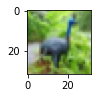

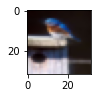

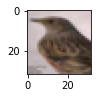

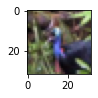

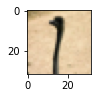

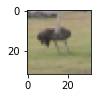

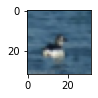

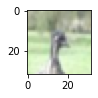

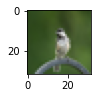

In [5]:
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
    plt.show()

## (c)

I would select all the pixels in K-mean (P = 6144000)

## (d)
In this section, I first run k-means clustering on a single image to test the algorithm. Then I run k-means clustering on all (6144000) pixels.

In [6]:
class KMeans:
    def __init__(self, n_cluster, max_iter=100, e=0.0001):
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.e = e
    
    def fit_opt(self, x):
        np.random.seed(42)
        N, D = x.shape
        centroids = x[np.random.choice(len(x), self.n_cluster)]
        gamma = np.zeros(N)
        sse = None
        
        for i in range(self.max_iter):
            # Assign each data point to nearest centroid
            distance = ((np.reshape(x, (N, 1, D)) -  centroids) ** 2).sum(axis=2)
            gamma = np.argmin(distance, axis=1)
            
            # Computer SSE to check for convergence
            sse_new = ((x - centroids[gamma.astype(int)]) ** 2).sum() / N
            if sse is None:
                sse = sse_new
            elif abs(sse_new - sse) < self.e:
                break
            else:
                sse = sse_new
            
            # Compute new centroids as mean of data points in each cluster
            centroids_new = np.zeros((self.n_cluster, D))

            for centroid_ind in range(self.n_cluster):
                cluster_data = x[gamma == centroid_ind]
                if(cluster_data.size != 0):
                    centroids_new[centroid_ind] = cluster_data.mean(axis=0)
                else:
                    centroids_new[centroid_ind] = centroids[np.random.randint(self.n_cluster, size=1)]
                
            centroids = centroids_new
            
        return centroids, i + 1

In [7]:
def get_k_means_plus_plus_center_indices(n, n_cluster, x, generator=np.random):
    '''
    :param n: number of samples in the data
    :param n_cluster: the number of cluster centers required
    :param x: data - numpy array of points
    :param generator: random number generator. Use it in the same way as np.random.

    :return: the center points array of length n_clusters with each entry being the *index* of a sample
             chosen as centroid.
    '''
    centers = []
    initial = generator.randint(0, n)
    centers.append(initial)
    prob = np.zeros(n)
    for k in range(1, n_cluster):
        i = 0
        for data in x:
            prob[i] = np.min([float(np.linalg.norm(data - x[centers[j]]) ** 2) for j in range(k)])
            i += 1
        prob = prob / sum(prob)
        r = generator.rand()
        m = 0
        while r > 0:
            r -= prob[m]
            m += 1
        centers.append(m - 1)
    return centers

In [8]:
im = X_train[0].copy()

In [9]:
def transform_image(image, centroids):
    N, M = image.shape[:2]
    distances = ((np.reshape(image, (N, M, 1, 3)) - centroids) ** 2).sum(axis = 3)
    centroid_indices = np.argmin(distances, axis=2)
    
    return centroids[centroid_indices]

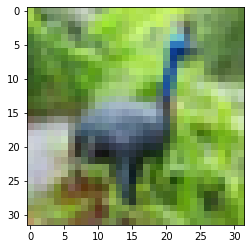

In [10]:
plt.imshow(im)

In [11]:
im.astype(np.float32)

array([[[164., 206.,  84.],
        [105., 140.,  61.],
        [118., 148., 101.],
        ...,
        [109., 147.,  73.],
        [108., 147.,  69.],
        [ 91., 129.,  57.]],

       [[167., 213.,  84.],
        [116., 160.,  49.],
        [ 72., 109.,  43.],
        ...,
        [105., 142.,  79.],
        [105., 142.,  72.],
        [ 89., 127.,  57.]],

       [[140., 191.,  65.],
        [142., 193.,  66.],
        [119., 163.,  79.],
        ...,
        [104., 139.,  84.],
        [ 84., 120.,  58.],
        [ 78., 115.,  49.]],

       ...,

       [[139., 148.,  81.],
        [142., 155.,  74.],
        [135., 156.,  72.],
        ...,
        [ 89., 134.,  28.],
        [ 97., 148.,  24.],
        [126., 176.,  49.]],

       [[163., 157.,  85.],
        [153., 164.,  82.],
        [146., 164.,  90.],
        ...,
        [ 85., 130.,  19.],
        [ 98., 148.,  27.],
        [127., 178.,  48.]],

       [[183., 153., 102.],
        [176., 182., 116.],
        [154., 1

Centroids computed in 27 iterations
[[122.65384615 148.30769231  77.80769231]
 [ 63.68        90.34        29.42      ]
 [107.125      140.1         79.225     ]
 [192.86       202.8        192.8       ]
 [168.22641509 219.58490566  80.11320755]
 [107.          90.97142857  44.77142857]
 [161.3        183.1        168.64      ]
 [121.525      167.625       61.725     ]
 [147.66666667 155.33333333  86.88888889]
 [156.75757576 197.42424242 108.10606061]
 [140.         160.28571429 126.03571429]
 [131.96551724 172.44827586  93.89655172]
 [ 34.71428571  48.42857143  38.34285714]
 [116.71428571 137.28571429 106.14285714]
 [ 92.19565217 117.54347826  68.93478261]
 [124.5        179.025       43.25      ]
 [ 80.8974359  117.44871795  42.87179487]
 [ 62.08333333  99.95833333 134.29166667]
 [103.07843137 142.7254902   54.07843137]
 [143.54385965 193.70175439  71.63157895]
 [ 97.45652174 152.          28.65217391]
 [ 57.14285714  73.95238095  86.35714286]
 [106.96551724 130.03448276 150.96551724

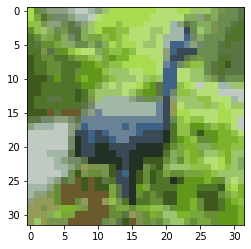

In [12]:
N, M = im.shape[:2]
data = im.reshape(N * M, 3)
k = 24

k_means = KMeans(k, 1000, 1e-6)
centroids, i = k_means.fit_opt(data)

print('Centroids computed in {} iterations'.format(i))
print(centroids)
im_comp = transform_image(im, centroids)

mse = np.sum((im - im_comp) ** 2) / (N * M)
print('Mean square error: {}\n'.format(mse))

plt.imshow(im_comp.astype(int))

In [13]:
centroids.astype(np.uint8)

array([[122, 148,  77],
       [ 63,  90,  29],
       [107, 140,  79],
       [192, 202, 192],
       [168, 219,  80],
       [107,  90,  44],
       [161, 183, 168],
       [121, 167,  61],
       [147, 155,  86],
       [156, 197, 108],
       [140, 160, 126],
       [131, 172,  93],
       [ 34,  48,  38],
       [116, 137, 106],
       [ 92, 117,  68],
       [124, 179,  43],
       [ 80, 117,  42],
       [ 62,  99, 134],
       [103, 142,  54],
       [143, 193,  71],
       [ 97, 152,  28],
       [ 57,  73,  86],
       [106, 130, 150],
       [181, 222, 117]], dtype=uint8)

In [14]:
colorful_centroids = np.array([[0,0,128], [230, 25, 75], [170, 255, 195], [255, 255, 255]])

Mean square error: 19307.0712890625



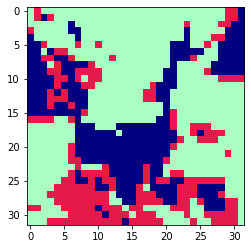

In [15]:
im_colorful = transform_image(im, colorful_centroids)

mse = np.sum((im - im_colorful) ** 2) / (N * M)
print('Mean square error: {}\n'.format(mse))

plt.imshow(im_colorful.astype(int))

Note that since I selected all the pixels, it would take a relatively long time to compute. So I store the pre-computed value to accelerate the debugging process. The computation code is commented above

In [16]:
#X = np.append(X_train,X_test,axis=0)
#N, M, L = X.shape[:3]
#data = X.reshape(N * M * L, 3)
#centroids, _ = k_means.fit_opt(data)
centroids = np.array([[176, 207, 235],
       [208, 191, 148],
       [ 16,  17,  14],
       [132, 154,  78],
       [ 93,  96,  89],
       [ 99,  84,  56],
       [ 97, 120,  50],
       [152, 107,  59],
       [174, 163, 122],
       [ 67,  65,  38],
       [244, 246, 244],
       [189, 190, 188],
       [151, 135, 104],
       [ 54,  97, 142],
       [221, 218, 209],
       [132, 171, 213],
       [121, 113,  85],
       [195, 168,  77],
       [141, 145, 140],
       [ 66,  72,  69],
       [116, 121, 118],
       [ 41,  43,  35],
       [167, 167, 161],
       [ 90, 136, 188]])

In [17]:
tetrachrome_train = np.empty((X_train.shape), dtype=np.uint8)
tetrachrome_test = np.empty((X_test.shape), dtype=np.uint8)
for i in range(X_train.shape[0]):
    tetrachrome_train[i] = (transform_image(X_train[i], centroids)).astype(np.uint8)
for i in range(X_test.shape[0]):
    tetrachrome_test[i] = (transform_image(X_test[i], centroids)).astype(np.uint8)
    
print(tetrachrome_train.shape)
print(tetrachrome_test.shape)

(5000, 32, 32, 3)
(1000, 32, 32, 3)


In [18]:
centroids.astype(np.uint8)

array([[176, 207, 235],
       [208, 191, 148],
       [ 16,  17,  14],
       [132, 154,  78],
       [ 93,  96,  89],
       [ 99,  84,  56],
       [ 97, 120,  50],
       [152, 107,  59],
       [174, 163, 122],
       [ 67,  65,  38],
       [244, 246, 244],
       [189, 190, 188],
       [151, 135, 104],
       [ 54,  97, 142],
       [221, 218, 209],
       [132, 171, 213],
       [121, 113,  85],
       [195, 168,  77],
       [141, 145, 140],
       [ 66,  72,  69],
       [116, 121, 118],
       [ 41,  43,  35],
       [167, 167, 161],
       [ 90, 136, 188]], dtype=uint8)

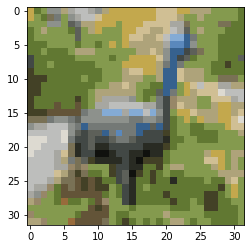

In [19]:
plt.imshow(tetrachrome_train[0])

In [20]:
centroids_encoding = np.identity(k).astype(np.uint8) # identity matrix as encoding
# Calculate the one hot encoded image which is going to be the output of the network. 
def one_hot_encode_image(image, centroids):
    N, M = image.shape[:2]
    distances = ((np.reshape(image, (N, M, 1, 3)) - centroids) ** 2).sum(axis = 3)
    centroid_indices = np.argmin(distances, axis=2)
    
    return centroids_encoding[centroid_indices]

In [21]:
N, M = X_train.shape[1:3]
one_hot_encoded_train = np.empty([X_train.shape[0], N, M, k], dtype=np.uint8)
one_hot_encoded_test = np.empty([X_test.shape[0], N, M, k], dtype=np.uint8)

for i in range(X_train.shape[0]):
    one_hot_encoded_train[i] = (one_hot_encode_image(X_train[i], centroids)).astype(np.uint8)
for i in range(X_test.shape[0]):
    one_hot_encoded_test[i] = (one_hot_encode_image(X_test[i], centroids)).astype(np.uint8)
    
print(one_hot_encoded_train.shape)
print(one_hot_encoded_test.shape)

(5000, 32, 32, 24)
(1000, 32, 32, 24)


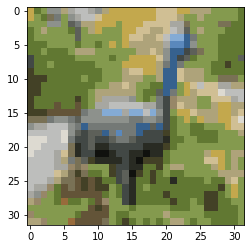

In [22]:
# Check if it is same as above
plt.imshow(np.dot(one_hot_encoded_train[0], centroids.astype(np.uint8)))

In [23]:
one_hot_encoded_train[0].shape

(32, 32, 24)

## (e)

In [24]:
grayscale_img = rgb2gray(im)

In [25]:
(grayscale_img * 255).astype(np.uint8)

array([[188, 126, 138, ..., 133, 133, 115],
       [193, 142,  96, ..., 129, 129, 113],
       [171, 173, 147, ..., 127, 107, 102],
       ...,
       [141, 146, 145, ..., 116, 128, 156],
       [153, 155, 154, ..., 112, 128, 157],
       [155, 175, 150, ..., 117, 116, 150]], dtype=uint8)

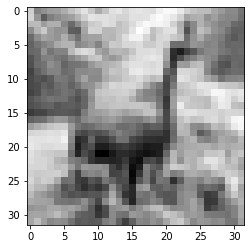

In [26]:
plt.imshow((grayscale_img * 255).astype(np.uint8), cmap=plt.cm.gray)

In [27]:
grayscale_img = rgb2gray(im)

In [28]:
grayscale_train = np.empty((X_train.shape[:3]), dtype=np.uint8)
grayscale_test = np.empty((X_test.shape[:3]), dtype=np.uint8)

In [29]:
print(grayscale_train.shape)
print(grayscale_test.shape)

(5000, 32, 32)
(1000, 32, 32)


In [30]:
for i in range(X_train.shape[0]):
    grayscale_img = rgb2gray(X_train[i])
    grayscale_train[i] = (grayscale_img * 255).astype(np.uint8)
    
for i in range(X_test.shape[0]):
    grayscale_img = rgb2gray(X_test[i])
    grayscale_test[i] = (grayscale_img * 255).astype(np.uint8)

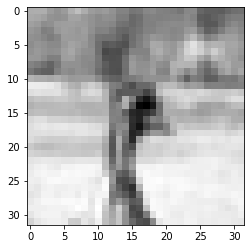

In [31]:
plt.imshow(grayscale_train[7], cmap=plt.cm.gray)

## (f)

In [32]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          102464    
Total params: 154,560
Trainable params: 154,560
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(1024*k, activation='relu'))
model.add(layers.Reshape((1024, k), input_shape=(1024*k,)))
model.add(layers.Softmax())

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              8

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

grayscale_train = grayscale_train.reshape(5000, 32, 32, 1)
grayscale_test = grayscale_test.reshape(1000, 32, 32, 1)

one_hot_encoded_train = one_hot_encoded_train.reshape(5000, 1024, k)
one_hot_encoded_test = one_hot_encoded_test.reshape(1000, 1024, k)

history = model.fit(grayscale_train, one_hot_encoded_train, epochs=30, validation_data=(grayscale_test, one_hot_encoded_test))

Epoch 1/30
157/157 [==============================] - 4s 15ms/step - loss: 3.1887 - accuracy: 0.0745 - val_loss: 3.0983 - val_accuracy: 0.0974
Epoch 2/30
157/157 [==============================] - 2s 13ms/step - loss: 3.0751 - accuracy: 0.1101 - val_loss: 3.0610 - val_accuracy: 0.1168
Epoch 3/30
157/157 [==============================] - 2s 14ms/step - loss: 3.0412 - accuracy: 0.1241 - val_loss: 3.0373 - val_accuracy: 0.1245
Epoch 4/30
157/157 [==============================] - 2s 14ms/step - loss: 3.0055 - accuracy: 0.1384 - val_loss: 3.0146 - val_accuracy: 0.1335
Epoch 5/30
157/157 [==============================] - 2s 14ms/step - loss: 2.9791 - accuracy: 0.1486 - val_loss: 3.0013 - val_accuracy: 0.1379
Epoch 6/30
157/157 [==============================] - 2s 14ms/step - loss: 2.9531 - accuracy: 0.1591 - val_loss: 2.9809 - val_accuracy: 0.1464
Epoch 7/30
157/157 [==============================] - 2s 14ms/step - loss: 2.9380 - accuracy: 0.1654 - val_loss: 2.9877 - val_accuracy: 0.1441

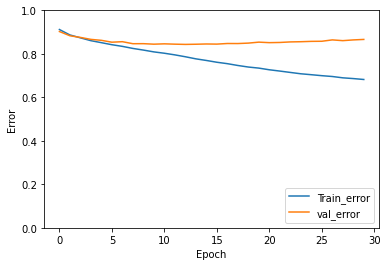

In [37]:
plt.plot(1 - np.array(history.history['accuracy']), label='Train_error')
plt.plot(1 - np.array(history.history['val_accuracy']), label = 'val_error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim([0, 1])
plt.legend(loc='lower right')

From the graph we can see that training error decreased continously, while the validation error stopped at around 0.85 after 15 epochs (actually increased later). Now we are going to compare the artificially colored versions of the first 10 images in the test set.

In [38]:
prediction = model.predict(grayscale_test.reshape(1000, 32, 32, 1))

In [39]:
prediction = prediction.reshape(1000, 32, 32, k)

In [40]:
one_hot_encoded_test = one_hot_encoded_test.reshape(1000, 32, 32, k)

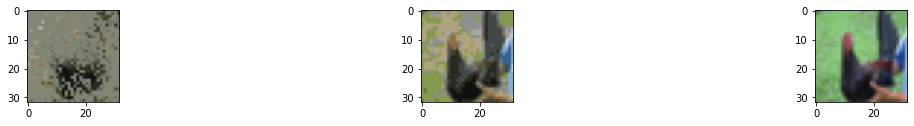

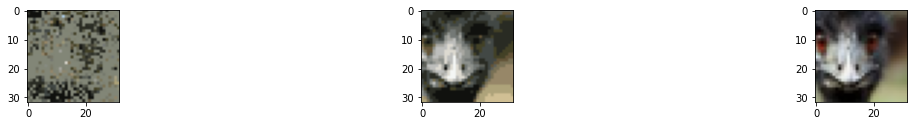

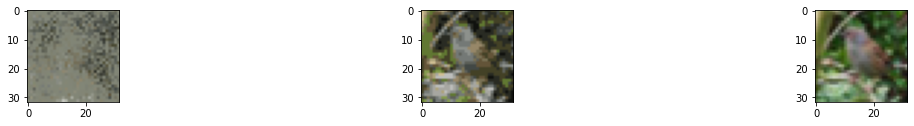

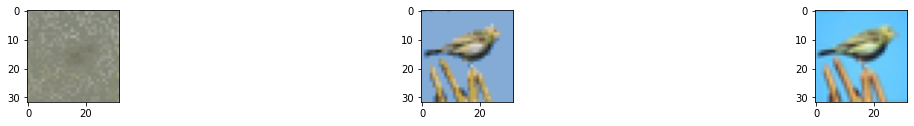

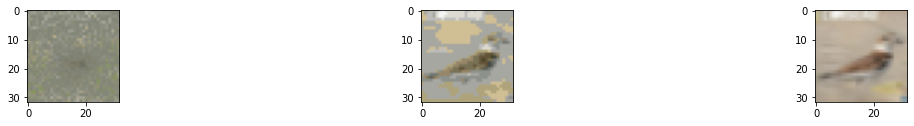

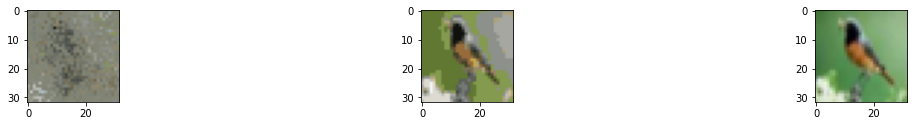

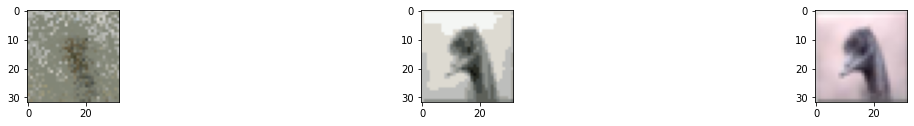

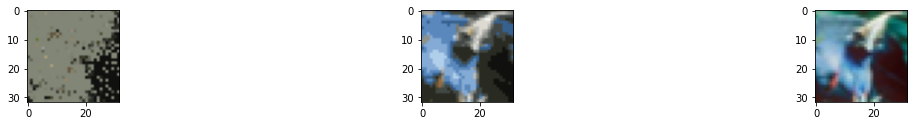

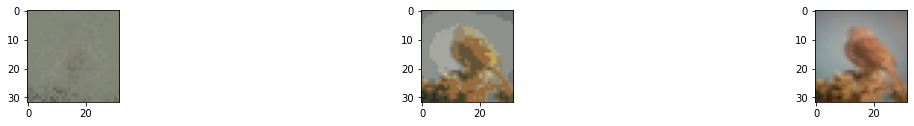

In [41]:
for i in range(0, 9):
    plt.figure(figsize=(20,20))
    plt.subplot(10, 3, 3*i+1)
    plt.imshow(np.dot(prediction[i], centroids).astype(np.uint8))
    plt.subplot(10, 3, 3*i+2)
    plt.imshow(np.dot(one_hot_encoded_test[i], centroids.astype(np.uint8)))
    plt.subplot(10, 3, 3*i+3)
    plt.imshow(X_test[i])
    plt.show()

From the graph we can see that the artificially colored versions doesn't not maintained the shape of the object well. (It starts to look worse and worse...). The tetrachrome image would look better setting, but the colored image still only captures several colors (green and gray).